# Enhancing Weather Forecasting for Aviation Operations

#### Jennifer Casias

Overview:
As a data scientist at Dublin Airport, I am forecasting rain and temperature by the hour to optimize deicing schedules. The FAA states that structural icing can occur when moisture is present in the air at temperatures between 4° and -10°C. To minimize additional deicing time, we need accurate weather forecasts.

Business Understanding:
Our stakeholder, Aer Lingus, needs to maintain flight schedules while ensuring safety and minimizing deicing time. We will forecast rain and temperature by the hour to optimize deicing schedules and prevent flight delays.

Data Understanding:
Our dataset is from Kaggle, sourced from Met Eireann. To download the dataset, please click [here](https://www.kaggle.com/datasets/conorrot/irish-weather-hourly-data). We'll focus on the rain and temperature variables to forecast weather conditions by hour. Analyzing these variables will provide insights for data-driven decisions to reduce deicing time and minimize flight delays.

In [ ]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
from neuralprophet import NeuralProphet
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv('Data/hrly_Irish_weather.csv')
df.head()

WARNING - (py.warnings._showwarnmsg) - /var/folders/lj/7nxfhmdd09gchghpg0g2z8vc0000gn/T/ipykernel_582/3785955756.py:1: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Data/hrly_Irish_weather.csv')



,county,station,latitude,longitude,date,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,sun,vis,clht,clamt
0,Galway,ATHENRY,53.289,-8.786,26-jun-2011 01:00,0.0,15.3,14.5,13.9,15.8,90,1016.0,8,190,NaN,NaN,NaN,NaN
1,Galway,ATHENRY,53.289,-8.786,26-jun-2011 02:00,0.0,14.7,13.7,12.9,14.9,89,1015.8,7,190,NaN,NaN,NaN,NaN
2,Galway,ATHENRY,53.289,-8.786,26-jun-2011 03:00,0.0,14.3,13.4,12.6,14.6,89,1015.5,6,190,NaN,NaN,NaN,NaN
3,Galway,ATHENRY,53.289,-8.786,26-jun-2011 04:00,0.0,14.4,13.6,12.8,14.8,90,1015.3,7,180,NaN,NaN,NaN,NaN
4,Galway,ATHENRY,53.289,-8.786,26-jun-2011 05:00,0.0,14.4,13.5,12.7,14.7,89,1015.1,6,190,NaN,NaN,NaN,NaN


In [3]:
df.station.unique()

array(['ATHENRY', 'BALLYHAISE', 'BELMULLET', 'CASEMENT', 'CLAREMORRIS',
       'CORK AIRPORT', 'DUBLIN AIRPORT', 'DUNSANY', 'FINNER', 'GURTEEN',
       'JOHNSTOWNII', 'KNOCK AIRPORT', 'MACE HEAD', 'MALIN HEAD',
       'MARKREE', 'MOORE PARK', 'MT DILLON', 'MULLINGAR', 'NEWPORT',
       'OAK PARK', 'PHOENIX PARK', 'ROCHES POINT', 'SHANNON AIRPORT',
       'SherkinIsland', 'VALENTIA OBSERVATORY'], dtype=object)

In [3]:
# Set stations
df = df[df['station'].isin(['DUBLIN AIRPORT'])]

# Set columns
df = df.loc[:, ['station','date','rain','temp']]

# Set to datetime
df['date'] = pd.to_datetime(df['date'])
df.head()

,station,date,rain,temp
1278447,DUBLIN AIRPORT,1990-01-01 00:00:00,0.1,9.0
1278448,DUBLIN AIRPORT,1990-01-01 01:00:00,0.0,8.9
1278449,DUBLIN AIRPORT,1990-01-01 02:00:00,0.0,8.8
1278450,DUBLIN AIRPORT,1990-01-01 03:00:00,0.0,9.0
1278451,DUBLIN AIRPORT,1990-01-01 04:00:00,0.6,9.0


In [4]:
# Count NaN values in all columns by year
nan_counts_by_year = df.groupby(lambda x: df.loc[x, 'date'].year).apply(lambda x: x.isna().sum())
print(nan_counts_by_year)

      station  date  rain  temp
1990        0     0     0     0
1991        0     0     0     0
1992        0     0     0     0
1993        0     0     0     0
1994        0     0     0     0
1995        0     0     0     0
1996        0     0     0     0
1997        0     0     0     0
1998        0     0     0     0
1999        0     0     0     0
2000        0     0     0     0
2001        0     0     0     0
2002        0     0     0     0
2003        0     0     0     0
2004        0     0     0     0
2005        0     0     0     0
2006        0     0     0     0
2007        0     0     0     0
2008        0     0     0     0
2009        0     0     0     0
2010        0     0     0     0
2011        0     0     0     0
2012        0     0     0     0
2013        0     0     0     0
2014        0     0     0     0
2015        0     0     0     0
2016        0     0     0     0
2017        0     0     0     0
2018        0     0     0     0
2019        0     0     0     0
2020    

In [5]:
# Convert columns to numerical
df['rain'] = pd.to_numeric(df['rain'], errors='coerce')
df['temp'] = pd.to_numeric(df['temp'], errors='coerce')
df.head()

,station,date,rain,temp
1278447,DUBLIN AIRPORT,1990-01-01 00:00:00,0.1,9.0
1278448,DUBLIN AIRPORT,1990-01-01 01:00:00,0.0,8.9
1278449,DUBLIN AIRPORT,1990-01-01 02:00:00,0.0,8.8
1278450,DUBLIN AIRPORT,1990-01-01 03:00:00,0.0,9.0
1278451,DUBLIN AIRPORT,1990-01-01 04:00:00,0.6,9.0


In [6]:
# Sanity check
df.dtypes

station            object
date       datetime64[ns]
rain              float64
temp              float64
dtype: object

In [7]:
# New dataframe by station
dub_air = df[df['station'] == 'DUBLIN AIRPORT']

# New dataframe by rain column 
dub_air_rain = dub_air[['date', 'rain']].copy()

# New dataframes by temp column 
dub_air_temp = dub_air[['date', 'temp']].copy()

# New dataframe & set index to date
rain = dub_air_rain.set_index("date")

# New dataframe & set index to date
temp = dub_air_temp.set_index("date")

## Exploratory Data Analysis

#### Rain

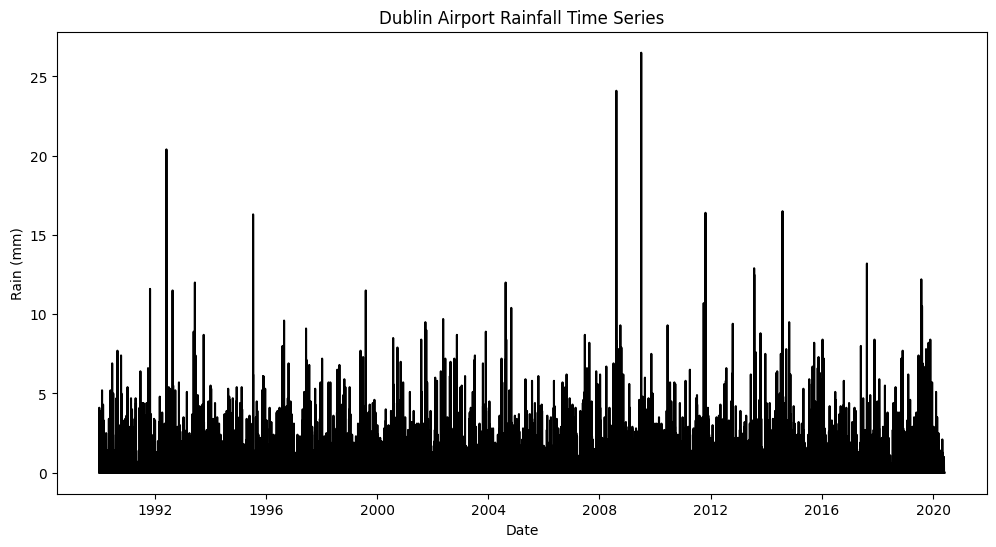

In [9]:
# Set the figure size
plt.figure(figsize=(12,6))

# Plot the rain data with a black line
plt.plot(dub_air_rain['date'], dub_air_rain['rain'], color='black')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Rain (mm)')
plt.title('Dublin Airport Rainfall Time Series')

# Show the plot
plt.show()

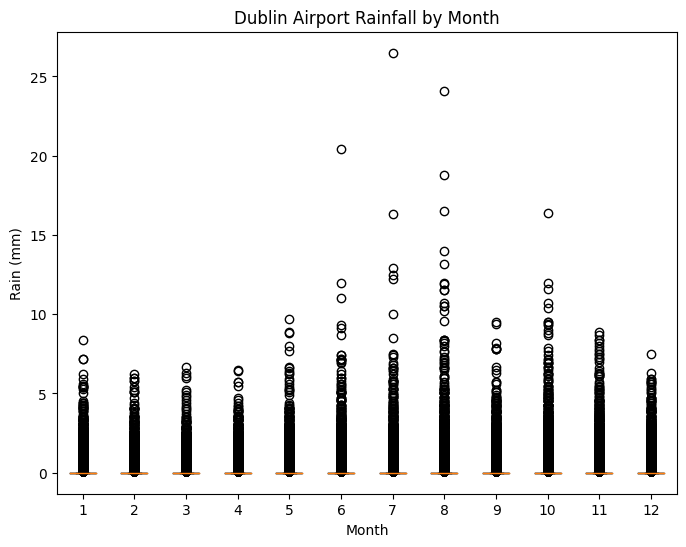

In [30]:
# Set the figure size
plt.figure(figsize=(8,6))

# Create a box plot of rainfall by month
dub_air_rain['month'] = dub_air_rain['date'].dt.month
plt.boxplot([dub_air_rain[dub_air_rain['month'] == i]['rain'] for i in range(1, 13)])

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Rain (mm)')
plt.title('Dublin Airport Rainfall by Month')

# Show the plot
plt.show()

#### Temp

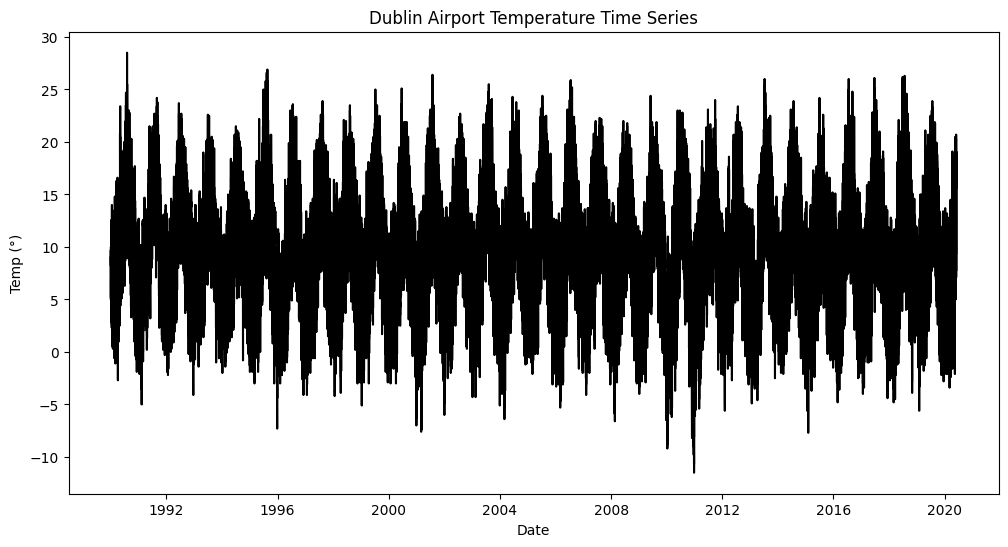

In [31]:
# Set the figure size
plt.figure(figsize=(12,6))

# Plot the temperature data with a black line
plt.plot(dub_air_temp['date'], dub_air_temp['temp'], color='black')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Temp (°)')
plt.title('Dublin Airport Temperature Time Series')

# Show the plot
plt.show()

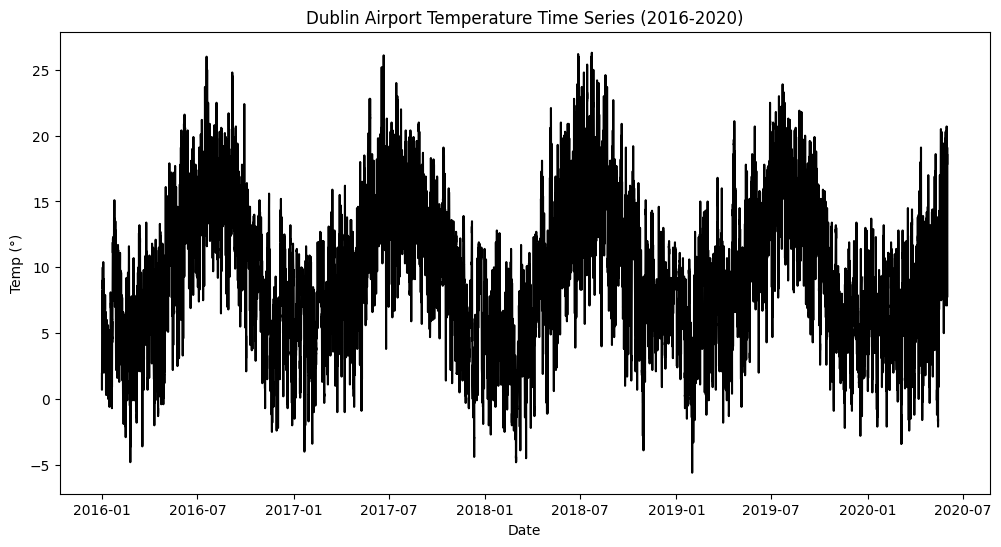

In [32]:
# Filter the dataframe to select data from 2016 to 2020
mask = (dub_air_temp['date'] >= '2016-01-01') & (dub_air_temp['date'] <= '2020-12-31')
dub_air_temp_2016_2020 = dub_air_temp.loc[mask]

# Set the figure size
plt.figure(figsize=(12,6))

# Plot the temperature data from 2016 to 2020
plt.plot(dub_air_temp_2016_2020['date'], dub_air_temp_2016_2020['temp'], color='black')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Temp (°)')
plt.title('Dublin Airport Temperature Time Series (2016-2020)')

# Show the plot
plt.show()

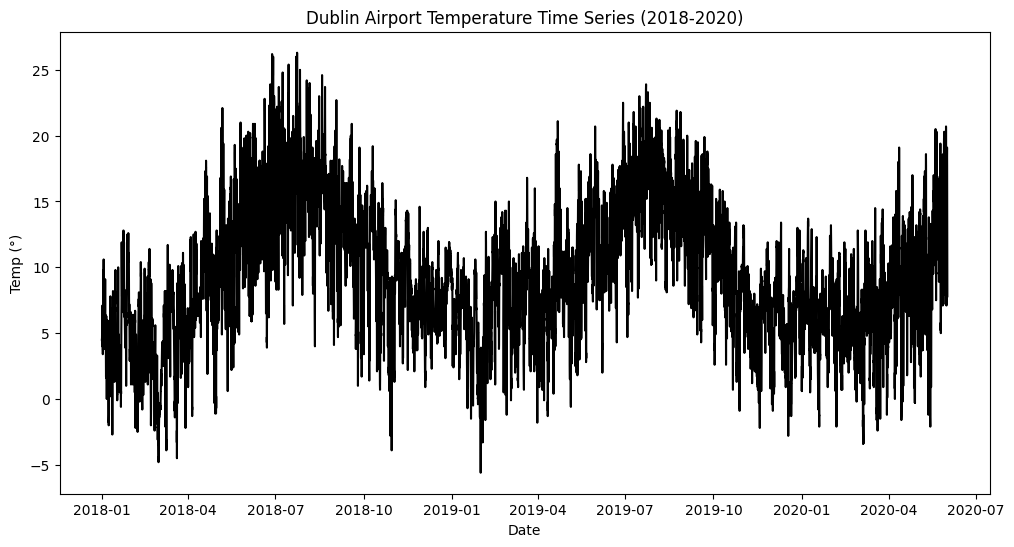

In [33]:
# Filter the dataframe to select data for the years 2019 and 2020
mask = (dub_air_temp['date'] >= '2018-01-01') & (dub_air_temp['date'] <= '2020-12-31')
dub_air_temp_2018_2020 = dub_air_temp.loc[mask]

# Set the figure size
plt.figure(figsize=(12,6))

# Plot the temperature data for the years 2019 and 2020
plt.plot(dub_air_temp_2018_2020['date'], dub_air_temp_2018_2020['temp'], color='black')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Temp (°)')
plt.title('Dublin Airport Temperature Time Series (2018-2020)')

# Show the plot
plt.show()

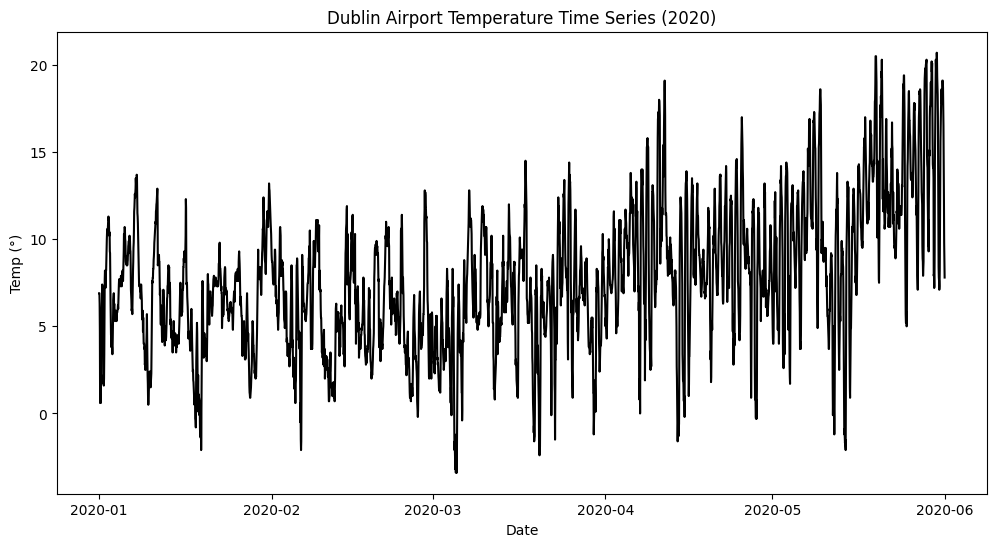

In [34]:
# Filter the dataframe to select data for the year 2020
mask = (dub_air_temp['date'] >= '2020-01-01') & (dub_air_temp['date'] <= '2020-12-31')
dub_air_temp_2020 = dub_air_temp.loc[mask]

# Set the figure size
plt.figure(figsize=(12,6))

# Plot the temperature data for the year 2020
plt.plot(dub_air_temp_2020['date'], dub_air_temp_2020['temp'], color='black')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Temp (°)')
plt.title('Dublin Airport Temperature Time Series (2020)')

# Show the plot
plt.show()

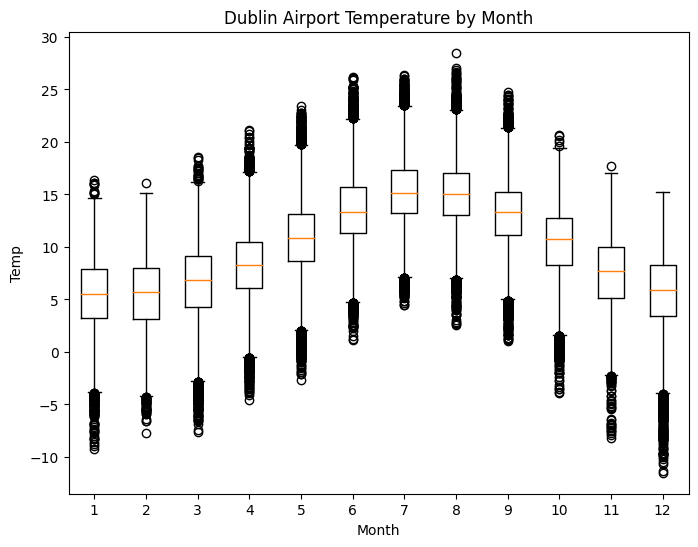

In [35]:
# Set the figure size
plt.figure(figsize=(8,6))

# Create a box plot of rainfall by month
dub_air_temp['month'] = dub_air_temp['date'].dt.month
plt.boxplot([dub_air_temp[dub_air_temp['month'] == i]['temp'] for i in range(1, 13)])

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Temp')
plt.title('Dublin Airport Temperature by Month')

# Show the plot
plt.show()

#### Rain

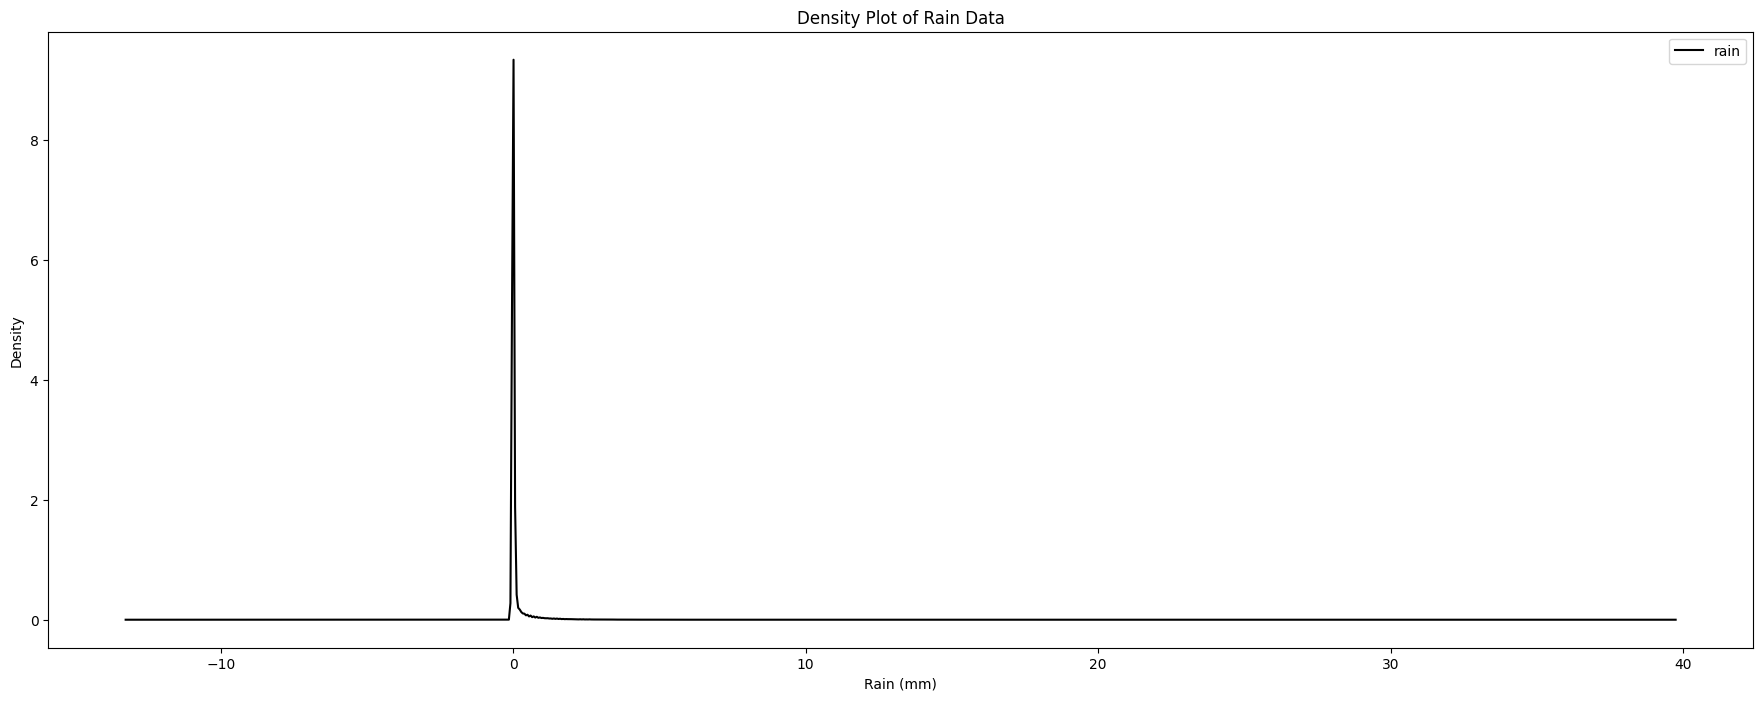

In [8]:
# Plot a density plot for the rain data
rain.plot(figsize=(22, 8), kind='kde', color='black')

# Add labels and title
plt.xlabel('Rain (mm)')
plt.ylabel('Density')
plt.title('Density Plot of Rain Data')

# Show the plot
plt.show()

<Figure size 2200x800 with 0 Axes>

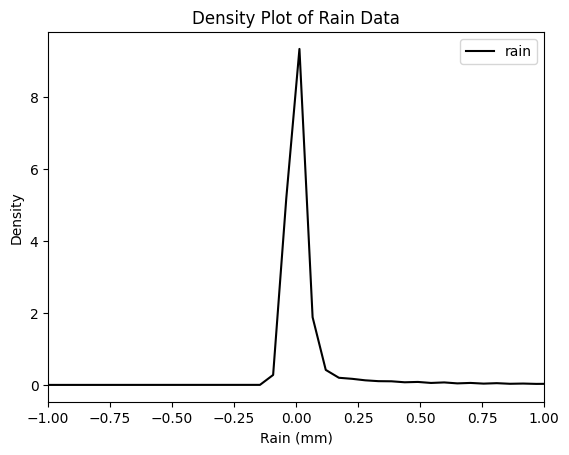

In [9]:
# Set the figure size
plt.figure(figsize=(22, 8))

# Plot a density plot of the rain data
rain.plot(kind='kde', color='black')

# Set the x-axis limits to zoom in on values between 0 and 20
plt.xlim(-1, 1)

# Add labels and title
plt.xlabel('Rain (mm)')
plt.ylabel('Density')
plt.title('Density Plot of Rain Data')

# Show the plot
plt.show()

#### Temp

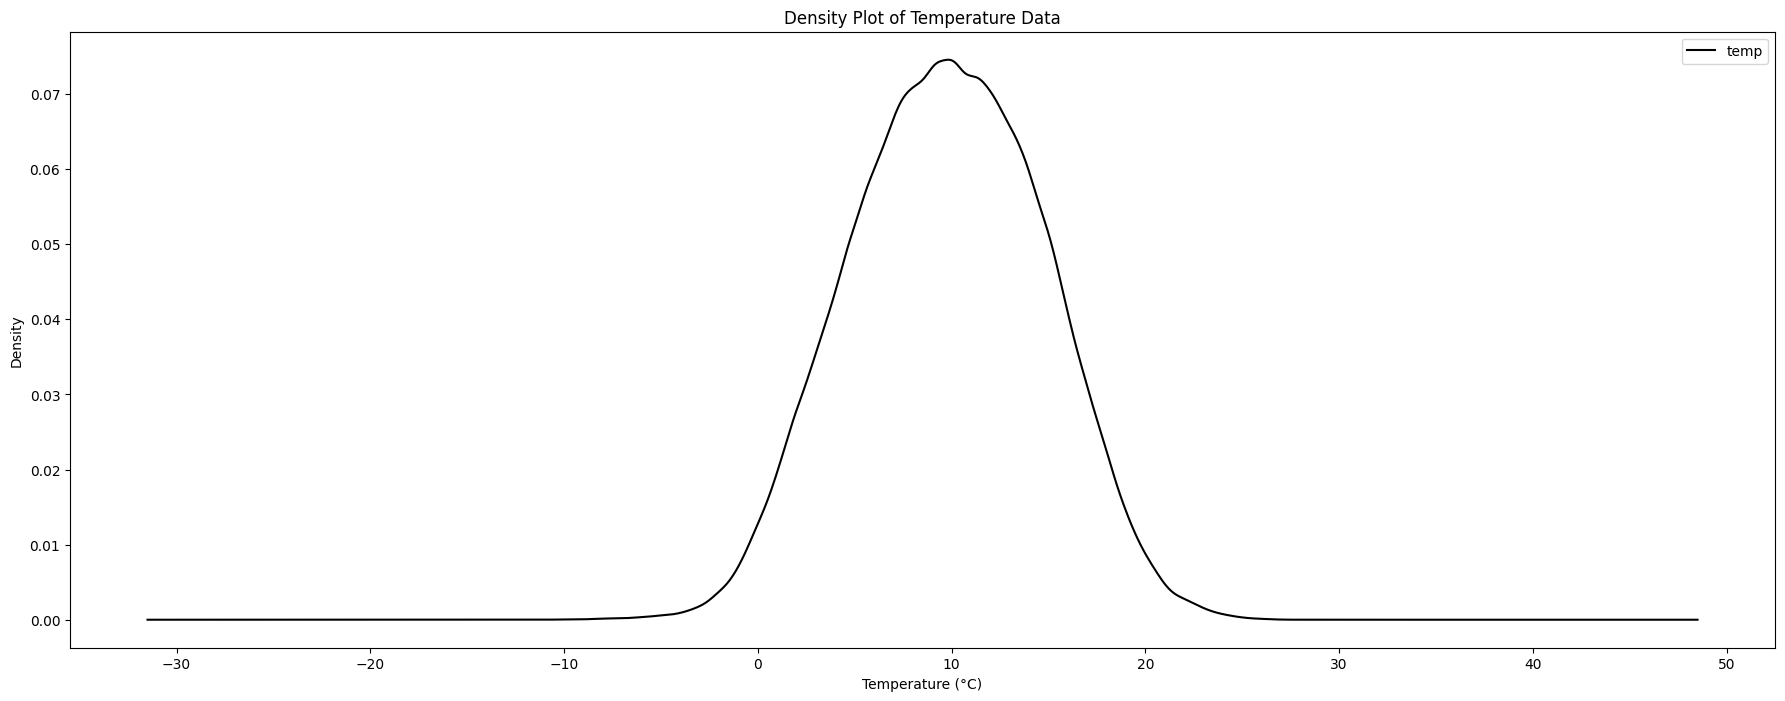

In [10]:
# Plot a density plot for the temperature data
temp.plot(figsize=(22, 8), kind='kde', color='black')

# Add labels and title
plt.xlabel('Temperature (°C)')
plt.ylabel('Density')
plt.title('Density Plot of Temperature Data')

# Show the plot
plt.show()

### Augmented Dickey-Fuller (ADF) test

In [11]:
# Perform ADF test on rainfall data
adf_result_rain = adfuller(dub_air_rain['rain'])

# Print the p-value of the test
print("Rainfall p-value: ", adf_result_rain[1])

Rainfall p-value:  0.0


In [20]:
# Perform ADF test on temperature data
adf_result_temp = adfuller(dub_air_temp['temp'])

# Print the p-value of the test
print("Temperature p-value: ", adf_result_temp[1])

Temperature p-value:  5.890973747384983e-30


Based on the ADF test result, it appears that the null hypothesis of the test (i.e., the time series has a unit root and is non-stationary) can be rejected with a high level of confidence, as the p-value of the test for both rainfall and temperature data is less than 0.05. Therefore, we can conclude that both the time series of **rainfall data and temperature data are stationary**. This means that the statistical properties of the data such as mean, variance, and autocorrelation are constant over time, which is an important assumption in many time series modeling techniques.

## Train-Test Split

#### Rain

In [13]:
# find the index which allows us to split off 20% of the data
cutoff_r = round(rain.shape[0]*0.8)

# Define train and test sets according to the index found above
train_r = rain[:cutoff_r]
test_r = rain[cutoff_r:]

# Print lengths
print("Train length:", len(train_r))
print("Test length:", len(test_r))

Train length: 213294
Test length: 53323


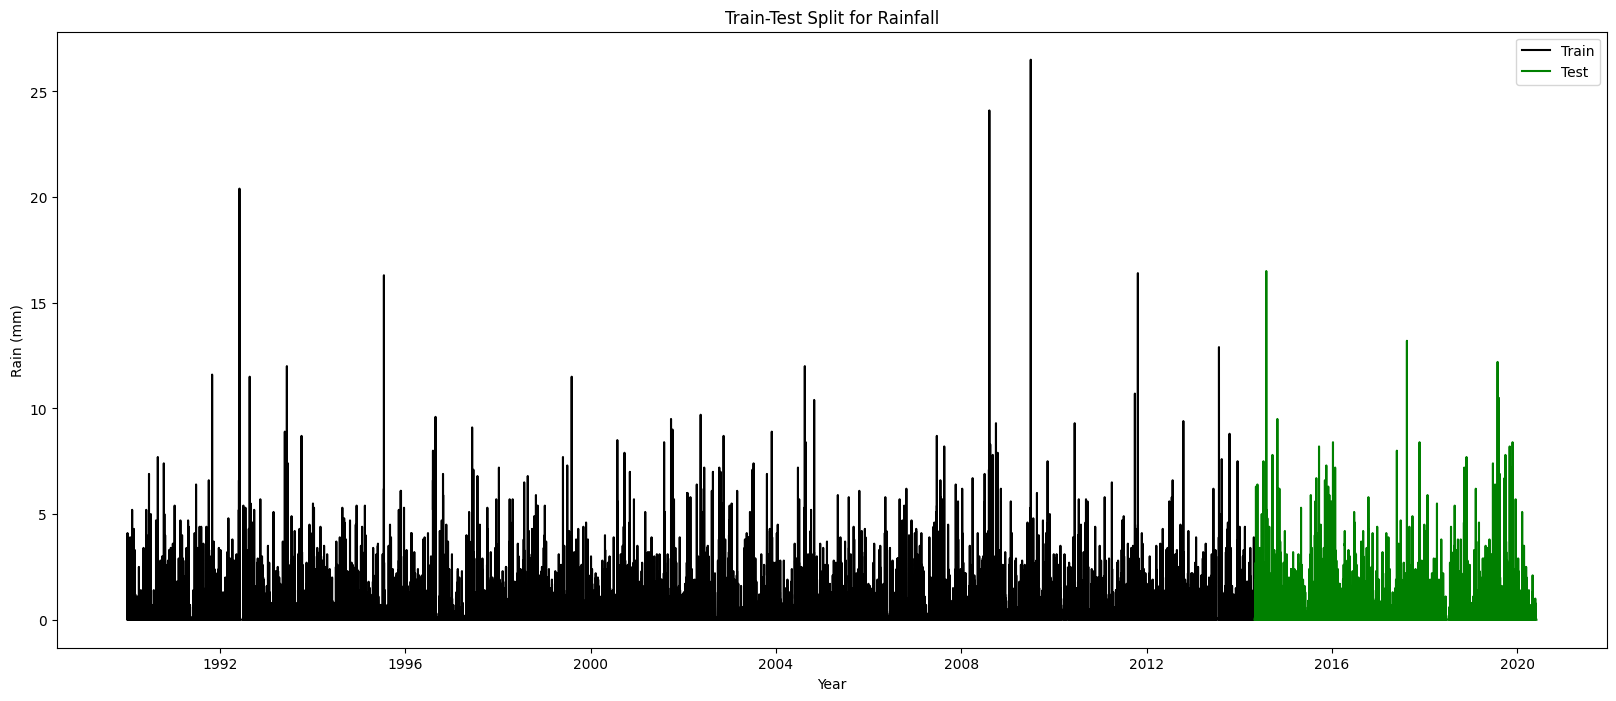

In [14]:
# Plot of our train test split
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(train_r.index, train_r['rain'], color='black', label='Train')
ax.plot(test_r.index, test_r['rain'], color='green', label='Test')
ax.set_title('Train-Test Split for Rainfall')
ax.set_xlabel('Year')
ax.set_ylabel('Rain (mm)')
plt.legend()

plt.show()

#### Temp

In [15]:
# find the index which allows us to split off 20% of the data
cutoff_t = round(temp.shape[0]*0.8)

# Define train and test sets according to the index found above
train_t = temp[:cutoff_t]
test_t = temp[cutoff_t:]

# Print lengths
print("Train length:", len(train_t))
print("Test length:", len(test_t))

Train length: 213294
Test length: 53323


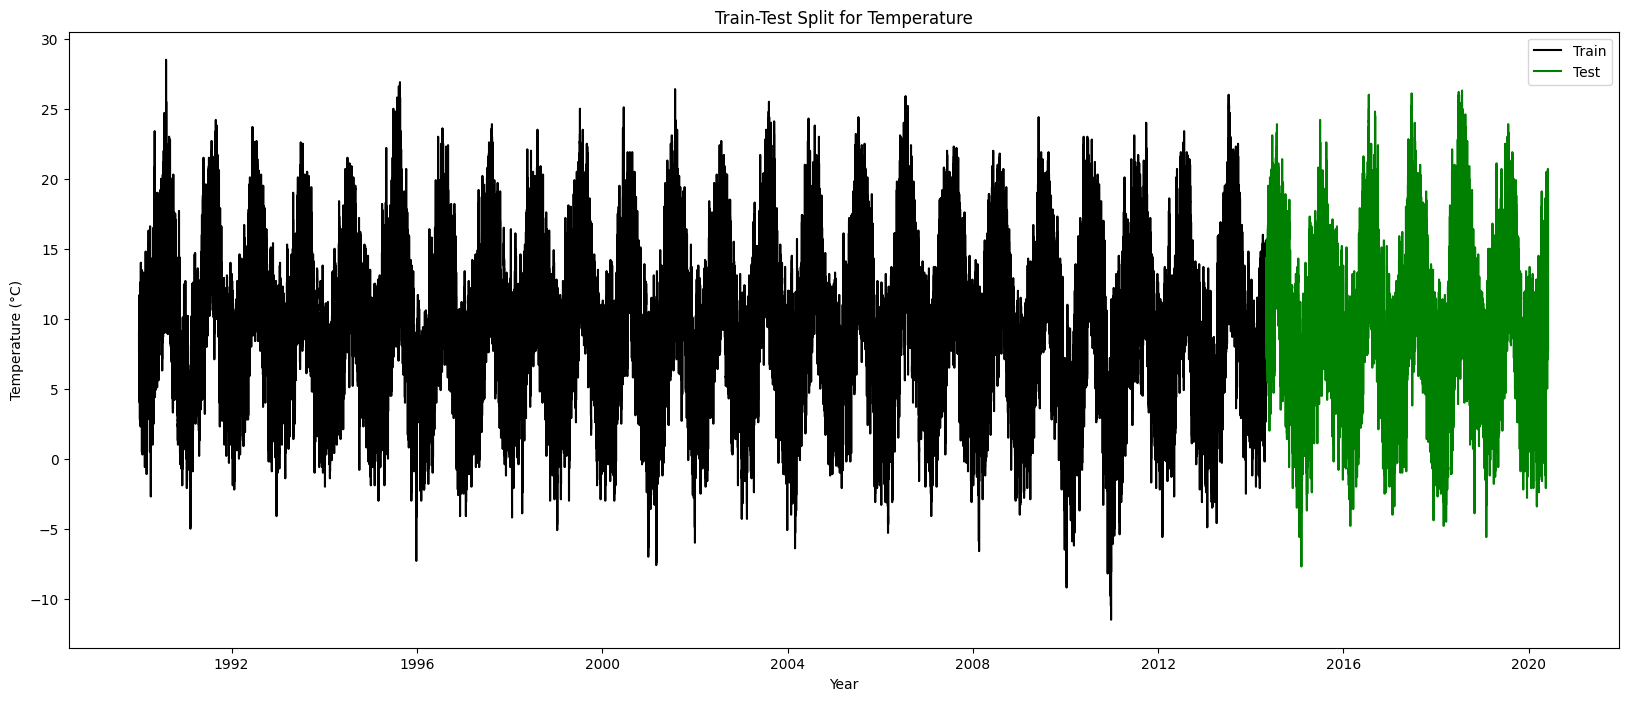

In [16]:
# Plot of our train test split with black and green lines
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(train_t.index, train_t['temp'], color='black', label='Train')
ax.plot(test_t.index, test_t['temp'], color='green', label='Test')
ax.set_title('Train-Test Split for Temperature')
ax.set_xlabel('Year')
ax.set_ylabel('Temperature (°C)')
plt.legend()

plt.show()

# Baseline Understanding: Naive Model

#### Rain

In [17]:
# Naive
rain_test_naive_hourly= test_r.shift(1).dropna()

#Calculate Root Mean Squared Error
rain_rmse_naive_hourly = mean_squared_error(test_r['rain'][1:], rain_test_naive_hourly, squared=False)
print("Naive Hourly Rainfall RMSE:", rain_rmse_naive_hourly)

Naive Hourly Rainfall RMSE: 0.4017337991564118


#### Temp

In [18]:
# Hourly
temp_test_naive_hourly= test_t.shift(1).dropna()

#Calculate Root Mean Squared Error
temp_rmse_naive_hourly = mean_squared_error(test_t['temp'][1:], temp_test_naive_hourly, squared=False)
print("Naive Hourly Temperature RMSE:", temp_rmse_naive_hourly)

Naive Hourly Temperature RMSE: 0.9434627183434129


# First Model - Random Walk Model

#### Rain

In [96]:
# Define y_train and y_test
y_train_rwr = train_r['rain']
y_test_rwr = test_r['rain']

# Create a NumPy array of the same length as y_test with the last observation in y_train
y_pred_rwr = np.full_like(y_test_rwr, y_train_rwr.iloc[-1])

# Calculate the RMSE
rmse_rwr = mean_squared_error(y_test_rwr, y_pred_rwr, squared=False)
print('Random Walk Rain RMSE:', rmse_rwr)

Random Walk Rain RMSE: 0.4372696346844811


#### Temp

In [55]:
# Define y_train and y_test
y_train_rwt = train_t['temp']
y_test_rwt = test_t['temp']

# Create a NumPy array of the same length as y_test with the last observation in y_train
y_pred_rwt = np.full_like(y_test_rwt, y_train_rwt.iloc[-1])

# Calculate the RMSE
rmse_rwt = mean_squared_error(y_test_rwt, y_pred_rwt, squared=False)
print('Random Walk Temp RMSE:', rmse_rwt)

Random Walk Temp RMSE: 5.40940812530831


# Second Model - Random Walk model using ARIMA modelling framework

#### Rain

In [56]:
# Convert the train data to a numpy array with float data type
train_r_array = train_r.to_numpy(dtype=np.float)

# Fit the random walk model
RW_rain = ARIMA(train_r_array, order=(0, 1, 0)).fit()

# Print out summary information on the fit
print(RW_rain.summary())

WARNING - (py.warnings._showwarnmsg) - /var/folders/lj/7nxfhmdd09gchghpg0g2z8vc0000gn/T/ipykernel_29843/2398562200.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_r_array = train_r.to_numpy(dtype=np.float)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               213294
Model:                 ARIMA(0, 1, 0)   Log Likelihood             -110261.135
Date:                Wed, 19 Apr 2023   AIC                         220524.270
Time:                        11:14:40   BIC                         220534.540
Sample:                             0   HQIC                        220527.284
                             - 213294                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.1646   3.83e-05   4297.584      0.000       0.165       0.165
Ljung-Box (L1) (Q):               18584.87   Jarque-Bera (JB):        1053983819.16
Prob(Q):                              0.00   Pr

In [97]:
# Forecast the test set using the random walk model
predictions_rwar = RW_rain.forecast(steps=len(test_r))

# Calculate the RMSE
rmse_rwar = mean_squared_error(test_r, predictions_rwar, squared=False)

print('Random Walk ARIMA Rainfall RMSE:', rmse_rwar)

Random Walk ARIMA Rainfall RMSE: 0.4372696346844811


#### Temp

In [58]:
# Convert the train data to a numpy array with float data type
train_t_array = train_t.to_numpy(dtype=np.float)

# Fit the random walk model
RW_temp = ARIMA(train_t_array, order=(0, 1, 0)).fit()

# Print out summary information on the fit
print(RW_temp.summary())

WARNING - (py.warnings._showwarnmsg) - /var/folders/lj/7nxfhmdd09gchghpg0g2z8vc0000gn/T/ipykernel_29843/1265869989.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_t_array = train_t.to_numpy(dtype=np.float)



                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:               213294
Model:                 ARIMA(0, 1, 0)   Log Likelihood             -273092.601
Date:                Wed, 19 Apr 2023   AIC                         546187.202
Time:                        11:15:53   BIC                         546197.473
Sample:                             0   HQIC                        546190.217
                             - 213294                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.7579      0.001    523.081      0.000       0.755       0.761
Ljung-Box (L1) (Q):               21822.47   Jarque-Bera (JB):             87813.63
Prob(Q):                              0.00   Pr

In [180]:
# Forecast the test set using the random walk model
predictions_rwat = RW_temp.forecast(steps=len(test_t))

# Calculate the RMSE
rmse_rwat = mean_squared_error(test_t, predictions_rwat, squared=False)

print('Random Walk ARIMA Temp RMSE:', rmse_rwat)

Random Walk ARIMA Temp RMSE: 5.4094081253083095


In [60]:
RW_temp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:               213294
Model:                 ARIMA(0, 1, 0)   Log Likelihood             -273092.601
Date:                Wed, 19 Apr 2023   AIC                         546187.202
Time:                        11:16:28   BIC                         546197.473
Sample:                             0   HQIC                        546190.217
                             - 213294                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.7579      0.001    523.081      0.000       0.755       0.761
===================================================================================
Ljung-Box (L1) (Q):               21822.47   Jarque-Bera (JB):             87813.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.24   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Third Model - Autoregression Model

Autoregression model using only 1 previous value.

#### Rain

In [17]:
# Fit an ARIMA(1,0,0) model
AR1_rain = ARIMA(train_r, order=(1,0,0)).fit()

# Print out summary information on the fit
print(AR1_rain.summary())

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)



                               SARIMAX Results                                
Dep. Variable:                   rain   No. Observations:               213294
Model:                 ARIMA(1, 0, 0)   Log Likelihood              -81919.939
Date:                Thu, 20 Apr 2023   AIC                         163845.878
Time:                        16:09:42   BIC                         163876.690
Sample:                    01-01-1990   HQIC                        163854.922
                         - 05-02-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0875      0.002     37.113      0.000       0.083       0.092
ar.L1          0.5333      0.000   1823.272      0.000       0.533       0.534
sigma2         0.1262   3.24e-05   3894.240      0.0

In [18]:
# Generate predictions on the test set
predictions_AR1r = AR1_rain.predict(start=test_r.index[0], end=test_r.index[-1], typ='levels')

# Calculate the RMSE
rmse_AR1r = mean_squared_error(test_r['rain'], predictions_AR1r, squared=False)
print('AR1 Rain RMSE:', rmse_AR1r)

AR1 Rain RMSE: 0.42830670122532616


#### Temp

In [63]:
# Fit an ARIMA(1,0,0) model
AR1_temp = ARIMA(train_t, order=(1,0,0)).fit()

# Print out summary information on the fit
print(AR1_temp.summary())

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)



                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:               213294
Model:                 ARIMA(1, 0, 0)   Log Likelihood             -272258.657
Date:                Wed, 19 Apr 2023   AIC                         544523.313
Time:                        11:17:38   BIC                         544554.124
Sample:                    01-01-1990   HQIC                        544532.356
                         - 05-02-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7150      0.121     80.499      0.000       9.478       9.952
ar.L1          0.9844      0.000   2724.644      0.000       0.984       0.985
sigma2         0.7520      0.001    506.860      0.0

In [64]:
# Generate predictions on the test set
predictions_AR1t = AR1_temp.predict(start=test_t.index[0], end=test_t.index[-1], typ='levels')

# Calculate the RMSE
rmse_AR1t = mean_squared_error(test_t['temp'], predictions_AR1t, squared=False)
print('AR1 Temp RMSE:', rmse_AR1t)

AR1 Temp RMSE: 4.991179906863706


## Fourth Model - Moving Average Model

Moving Average model using only 1 previous error.

#### Rain

In [65]:
# Fit an ARMA(0,0,10) model
MA1_rain = ARIMA(train_r, order=(0,0,1)).fit()

# Print out summary information on the fit
print(MA1_rain.summary())

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)



                               SARIMAX Results                                
Dep. Variable:                   rain   No. Observations:               213294
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -91142.721
Date:                Wed, 19 Apr 2023   AIC                         182291.442
Time:                        11:18:21   BIC                         182322.253
Sample:                    01-01-1990   HQIC                        182300.485
                         - 05-02-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0875      0.002     56.372      0.000       0.084       0.091
ma.L1          0.4347      0.000   1359.656      0.000       0.434       0.435
sigma2         0.1376   3.82e-05   3606.524      0.0

In [66]:
# Use the trained model to make predictions on the test set
predictions_mar = MA1_rain.predict(start=test_r.index[0], end=test_r.index[-1], typ='levels')

# Calculate and print the RMSE
rmse_mar = np.sqrt(mean_squared_error(test_r['rain'], predictions_mar))
print("Moving Average Rain Test RMSE:", rmse_mar)

Moving Average Rain Test RMSE: 0.4283069398662131


#### Temp

In [67]:
# Fit an ARMA(0,0,10) model
MA1_temp = ARIMA(train_t, order=(0,0,1)).fit()

# Print out summary information on the fit
print(MA1_temp.summary())

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as startin

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:               213294
Model:                 ARIMA(0, 0, 1)   Log Likelihood             -515971.231
Date:                Wed, 19 Apr 2023   AIC                        1031948.463
Time:                        11:19:15   BIC                        1031979.274
Sample:                    01-01-1990   HQIC                       1031957.506
                         - 05-02-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7150      0.011    865.985      0.000       9.693       9.737
ma.L1          0.9047      0.001   1028.584      0.000       0.903       0.906
sigma2         7.3908      0.024    311.313      0.0

In [68]:
# Use the trained model to make predictions on the test set
predictions_mat = MA1_temp.predict(start=test_t.index[0], end=test_t.index[-1], typ='levels')

# Calculate and print the RMSE
rmse_mat = np.sqrt(mean_squared_error(test_t['temp'], predictions_mat))
print("Moving Average Temp Test RMSE:", rmse_mat)

Moving Average Temp Test RMSE: 4.990526432105825


# Fourth Model- ARMA(1,0,1)

Combine our 2nd and 3rd models and try an ARMA model with 1 AR and 1 MA term.

#### Rain

In [73]:
# Fit an ARMA(1,0,1) model to the training data
ARMA101r = ARIMA(train_r['rain'], order=(1, 0, 1))
ARMA101r_fit = ARMA101r.fit()

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)



In [75]:
# Make predictions on the test set
predictions_arma101r = ARMA101r_fit.predict(start=test_r.index[0], end=test_r.index[-1])

# Calculate the RMSE
rmse_arma101r = np.sqrt(mean_squared_error(test_r['rain'], predictions_arma101r))

# Print the RMSE
print("ARMA(1,0,1) Rainfall RMSE:", rmse_arma101r)

ARMA(1,0,1) Rainfall RMSE: 0.42830662671979264


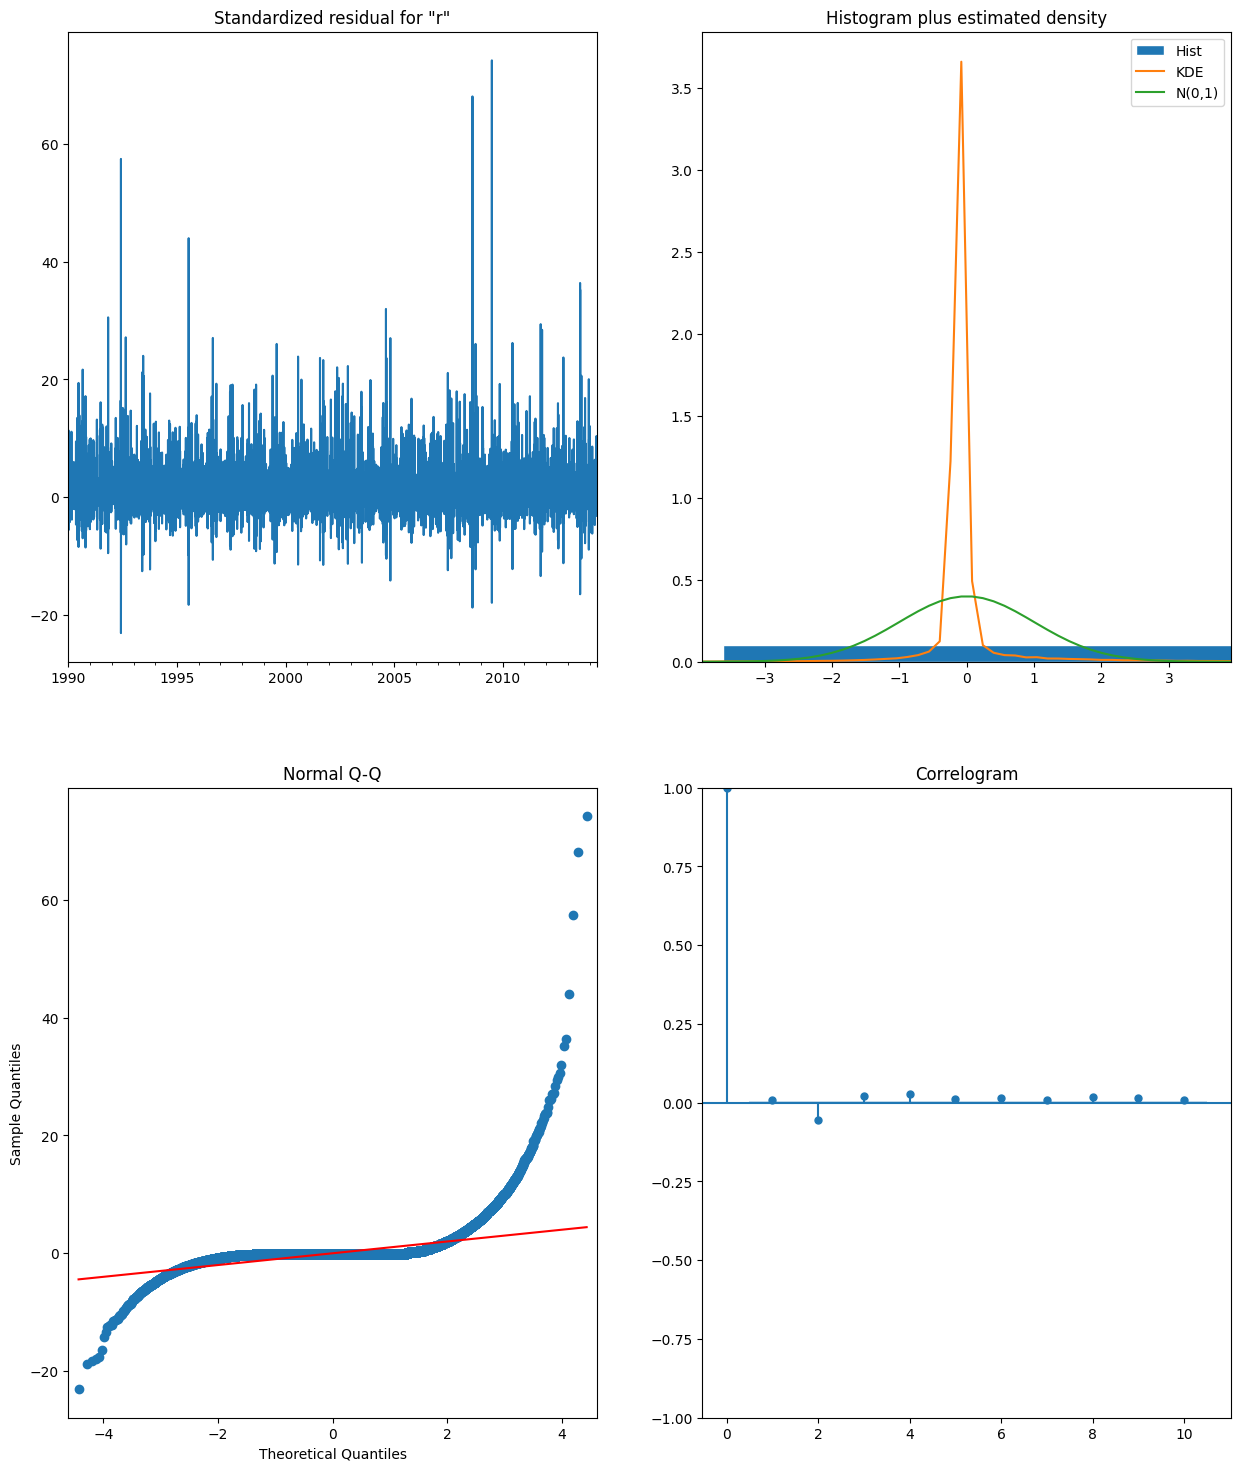

In [113]:
# Call plot_diagnostics() on the final model
ARMA101r_fit.plot_diagnostics(figsize=(15, 18))
plt.show()

#### Temp

In [76]:
# Fit an ARMA(1,0,1) model
ARMA101_temp = ARIMA(train_t, order=(1,0,1)).fit()

# Print out summary information on the fit
print(ARMA101_temp.summary())

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/envs/learn-env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)



                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:               213294
Model:                 ARIMA(1, 0, 1)   Log Likelihood             -263523.139
Date:                Wed, 19 Apr 2023   AIC                         527054.278
Time:                        11:24:43   BIC                         527095.360
Sample:                    01-01-1990   HQIC                        527066.335
                         - 05-02-2014                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7149      0.101     96.158      0.000       9.517       9.913
ar.L1          0.9777      0.000   2281.154      0.000       0.977       0.978
ma.L1          0.2481      0.001    176.259      0.0

In [77]:
#Root Mean Square Error(RMSE) For our ARMA(1,0,1) model
y_hat_arma101_temp = ARMA101_temp.predict(typ='levels')

ARMA101_temp_rmse = mean_squared_error(train_t, y_hat_arma101_temp, squared=False)

print(ARMA101_temp_rmse)

0.8323911449326704


In [98]:
# Generate predicted values on the test set
y_pred_arma101t_test = ARMA101_temp.predict(start=test_t.index[0], end=test_t.index[-1], typ='levels')

# Calculate RMSE
test_arma101t_rmse = mean_squared_error(test_t, y_pred_arma101t_test, squared=False)
print("ARMA101 Temp Test RMSE:", test_arma101t_rmse)

ARMA101 Temp Test RMSE: 4.99097626857259


## Fifth Model - Neural Prophet Model

#### Dataframes

In [79]:
# Dublin Airport Rain
np_dar = dub_air_rain[['date', 'rain']]
np_dar.columns = ['ds', 'y']

# Dublin Airport Temp
np_dat = dub_air_temp[['date', 'temp']]
np_dat.columns = ['ds', 'y']

#### Rain

In [80]:
# Find the index which allows us to split off 20% of the data
cutoff_np_dar = round(np_dar.shape[0]*0.8)
cutoff_np_dar

213294

In [81]:
# Define train and test sets according to the index found above
train_np_dar = np_dar[:cutoff_np_dar]
test_np_dar = np_dar[cutoff_np_dar:]

# Print lengths
print("Train length:", len(train_np_dar))
print("Test length:", len(test_np_dar))

Train length: 213294
Test length: 53323


In [83]:
# Initialize and fit the model on the training data
m_np_dar = NeuralProphet()

m_np_dar.fit(train_np_dar, freq='H', epochs=20)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 100.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 128
Missing logger folder: /Users/jennifercasias/Flatiron_Projects/P5_Project/Timeseries_Irish_Rainfall/lightning_logs


Finding best initial lr:   0%|          | 0/283 [00:00<?, ?it/s]

2023-04-19 11:27:21.598075: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,0.486631,0.690275,0.515354,0.0,0
1,0.138814,0.380998,0.098657,0.0,1
2,0.122188,0.377249,0.094483,0.0,2
3,0.125539,0.378504,0.095552,0.0,3
4,0.128949,0.379308,0.096476,0.0,4
5,0.131034,0.378781,0.097134,0.0,5
6,0.130330,0.379369,0.096978,0.0,6
7,0.130361,0.378932,0.096956,0.0,7
8,0.129616,0.378329,0.096767,0.0,8
9,0.128689,0.378262,0.096537,0.0,9


In [86]:
future_np_dar = m_np_dar.make_future_dataframe(np_dar, periods=53323)
forecast_np_dar = m_np_dar.predict(future_np_dar)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 100.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.998% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.998% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 1667it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [88]:
# Extract actual values from the test set
y_true_dar = test_np_dar['y']

# Extract predicted values from the forecast
y_pred_dar = forecast_np_dar['yhat1'].iloc[:len(y_true_dar)]

# Compute MAE and RMSE
mae_npr = mean_absolute_error(y_true_dar, y_pred_dar)
rmse_npr = mean_squared_error(y_true_dar, y_pred_dar, squared=False)

# Print results
print("Neural Prophet Rain MAE: {:.4f}".format(mae_npr))
print("Neural Prophet Rain RMSE: {:.4f}".format(rmse_npr))

Neural Prophet Rain MAE: 0.1267
Neural Prophet Rain RMSE: 0.4299


#### Temp

In [89]:
# Find the index which allows us to split off 20% of the data
cutoff_np_dat = round(np_dat.shape[0]*0.8)
cutoff_np_dat

213294

In [90]:
# Define train and test sets according to the index found above
train_np_dat = np_dat[:cutoff_np_dat]
test_np_dat = np_dat[cutoff_np_dat:]

# Print lengths
print("Train length:", len(train_np_dat))
print("Test length:", len(test_np_dat))

Train length: 213294
Test length: 53323


In [103]:
# Initialize and fit the model on the training data
m_np_dat = NeuralProphet()

m_np_dat.fit(train_np_dat, freq='H', epochs=200)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 100.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 128


Finding best initial lr:   0%|          | 0/283 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,41.973751,49.324120,0.720359,0.0,0
1,15.048159,18.407766,0.118730,0.0,1
2,8.389338,10.861680,0.041900,0.0,2
3,4.017803,5.519703,0.011105,0.0,3
4,2.840832,3.695850,0.005522,0.0,4
...,...,...,...,...,...
195,2.335191,2.957171,0.003948,0.0,195
196,2.335003,2.957234,0.003948,0.0,196
197,2.334104,2.956292,0.003945,0.0,197
198,2.333767,2.955861,0.003944,0.0,198


In [105]:
future_np_dat = m_np_dat.make_future_dataframe(np_dat, periods=53323)
forecast_np_dat = m_np_dat.predict(future_np_dat)

INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 100.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.998% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H
INFO - (NP.df_utils._infer_frequency) - Major frequency H corresponds to 99.998% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - H


Predicting: 1667it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [107]:
# Extract actual values from the test set
y_true_dat = test_np_dat['y']

# Extract predicted values from the forecast
y_pred_dat = forecast_np_dat['yhat1'].iloc[:len(y_true_dat)]

# Compute MAE and RMSE
mae_npt = mean_absolute_error(y_true_dat, y_pred_dat)
rmse_npt = mean_squared_error(y_true_dat, y_pred_dat, squared=False)

# Print results
print("MAE: {:.4f}".format(mae_npt))
print("Neural Prophet Temp RMSE:", rmse_npt)

MAE: 3.3324
Neural Prophet Temp RMSE: 4.119194613182707


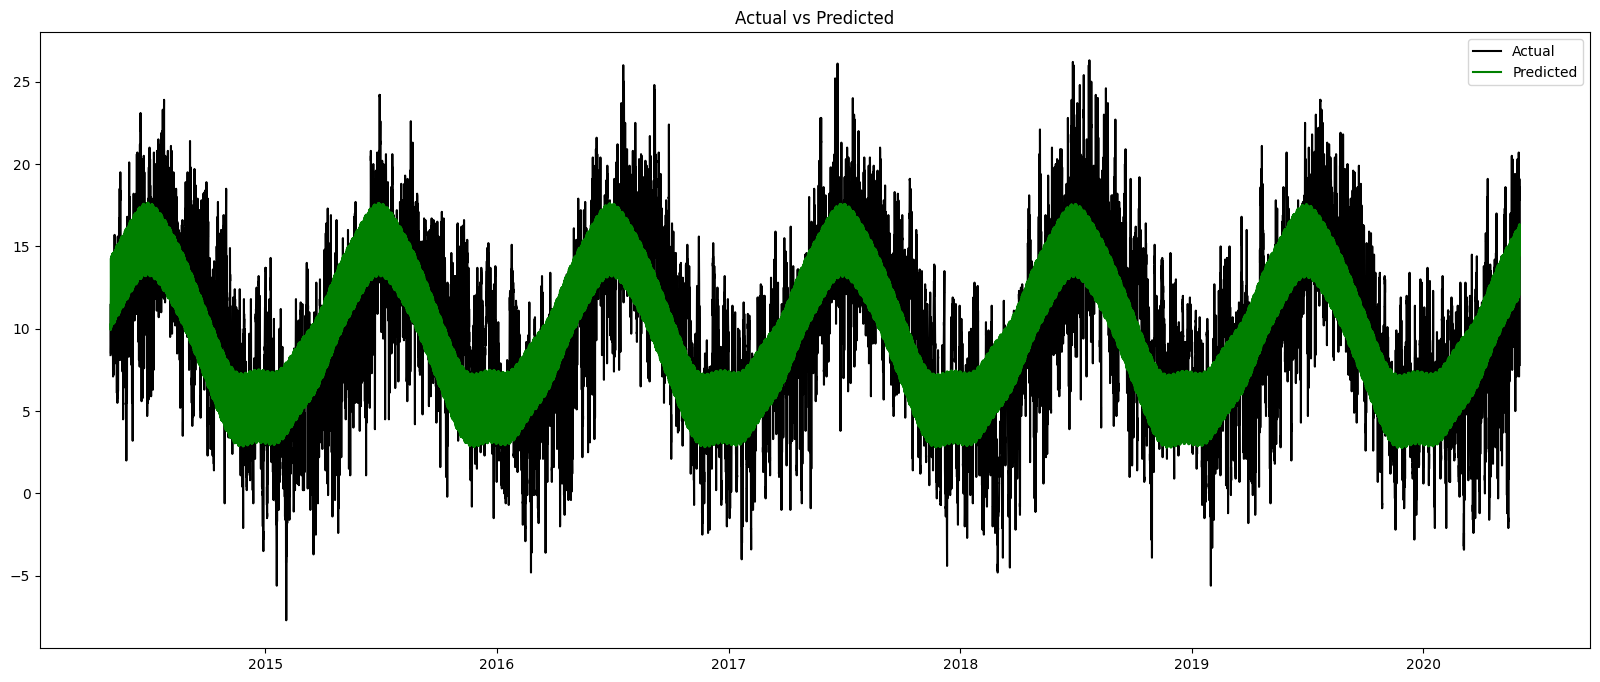

In [156]:
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(test_np_dat['ds'], y_true_dat, label='Actual', color='black')
ax.plot(test_np_dat['ds'], y_pred_dat, label='Predicted', color='green')
ax.set_title('Actual vs Predicted')
plt.legend()
plt.show()

## Final Model Selection

#### Rain

In [109]:
# Print results
print("Naive Hourly Rainfall RMSE:", rain_rmse_naive_hourly)
print('Random Walk Rainfall RMSE:', rmse_rwr)
print('Random Walk ARIMA Rainfall RMSE:', rmse_rwar)
print('AR1 Rainfall RMSE:', rmse_AR1r)
print("Moving Average Rainfall Test RMSE:", rmse_mar)
print("ARMA(1,0,1) Rainfall RMSE:", rmse_arma101r)
print("Neural Prophet Rain RMSE: {:.4f}".format(rmse_npr))

Naive Hourly Rainfall RMSE: 0.4017337991564118
Random Walk Rainfall RMSE: 0.4372696346844811
Random Walk ARIMA Rainfall RMSE: 0.4372696346844811
AR1 Rainfall RMSE: 0.42830670122532616
Moving Average Rainfall Test RMSE: 0.4283069398662131
ARMA(1,0,1) Rainfall RMSE: 0.42830662671979264
Neural Prophet Rain RMSE: 0.4299


#### Temp

In [114]:
# Print results
print("Naive Hourly Temperature RMSE:", temp_rmse_naive_hourly)
print('Random Walk Temperature RMSE:', rmse_rwt)
print('AR1 Temperature RMSE:', rmse_AR1t)
print("Moving Average Temp Test RMSE:", rmse_mat)
print("ARMA101 Temp Test RMSE:", test_arma101t_rmse)
print("Neural Prophet Temp RMSE:", rmse_npt)

Naive Hourly Temperature RMSE: 0.9434627183434129
Random Walk Temperature RMSE: 5.40940812530831
AR1 Temperature RMSE: 4.991179906863706
Moving Average Temp Test RMSE: 4.990526432105825
ARMA101 Temp Test RMSE: 4.99097626857259
Neural Prophet Temp RMSE: 4.119194613182707


# Evaluation

#### Rain

In [19]:
# Hourly
rain_test_naive_hourly= test_r.shift(1).dropna()

# Daily
rain_test_naive_daily= test_r.shift(24).dropna()

#Calculate Root Mean Squared Error
rain_rmse_naive_hourly = mean_squared_error(test_r['rain'][1:], rain_test_naive_hourly, squared=False)
rain_rmse_naive_daily = mean_squared_error(test_r['rain'][24:], rain_test_naive_daily, squared=False)

print("Naive Hourly Rainfall RMSE:", rain_rmse_naive_hourly)
print("Naive Daily Rainfall RMSE:", rain_rmse_naive_daily)

Naive Hourly Rainfall RMSE: 0.4017337991564118
Naive Daily Rainfall RMSE: 0.6005804055912745


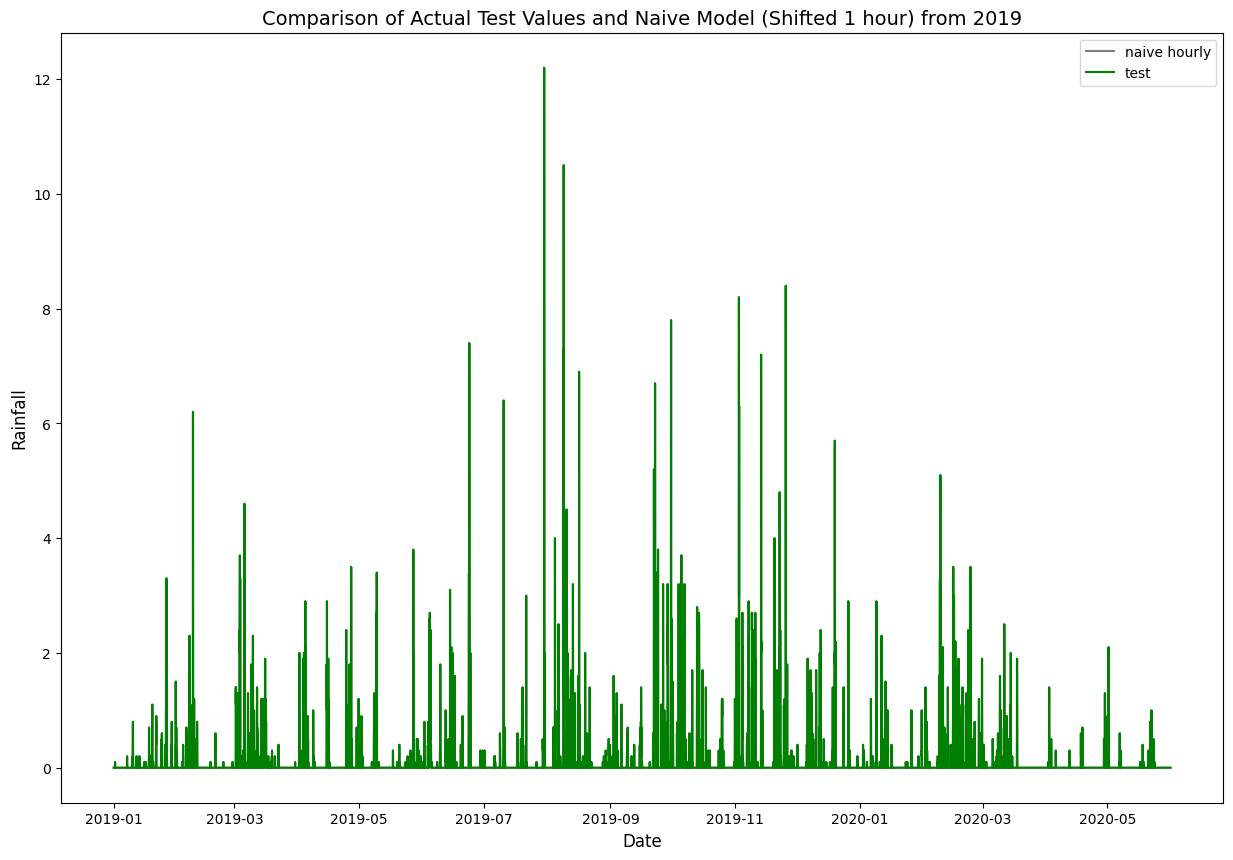

In [23]:
# Graph Test values with Naive Model (shifted 1 hour)- Zoomed in to 2019 onwards
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(rain_test_naive_hourly.loc['2019':], color='black', label= 'naive hourly', alpha= 0.5)
ax.plot(test_r.loc['2019':], color='green', label= 'test')

# Set axis labels and title
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Rainfall', fontsize=12)
ax.set_title('Comparison of Actual Test Values and Naive Model (Shifted 1 hour) from 2019', fontsize=14)

ax.legend();

#### Temp

In [24]:
# Hourly
temp_test_naive_hourly= test_t.shift(1).dropna()

# Daily
temp_test_naive_daily = test_t.shift(24).dropna()

#Calculate Root Mean Squared Error
temp_rmse_naive_hourly = mean_squared_error(test_t['temp'][1:], temp_test_naive_hourly, squared=False)
temp_rmse_naive_daily = mean_squared_error(test_t['temp'][24:], temp_test_naive_daily, squared=False)

print("Naive Hourly Temperature RMSE:", temp_rmse_naive_hourly)
print("Daily Hourly Temperature RMSE:", temp_rmse_naive_daily)

Naive Hourly Temperature RMSE: 0.9434627183434129
Daily Hourly Temperature RMSE: 3.091478049981667


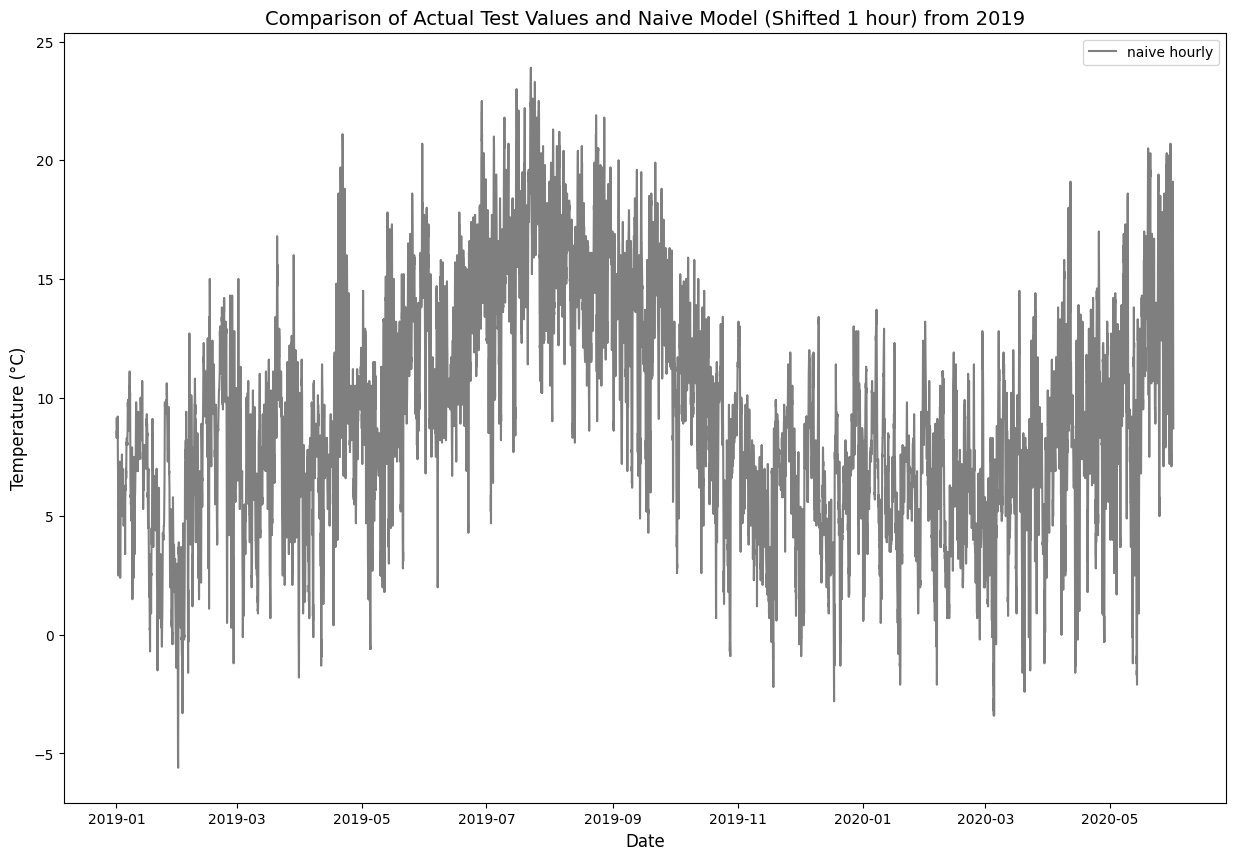

In [29]:
# Graph Test values with Naive Model (shifted 1 hour)- Zoomed in to 2019 onwards
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(temp_test_naive_hourly.loc['2019':], color='black', label= 'naive hourly', alpha= 0.5)
# ax.plot(test_t.loc['2019':], color='green', label= 'test')

# Set axis labels and title
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Temperature (°C)', fontsize=12)
ax.set_title('Comparison of Actual Test Values and Naive Model (Shifted 1 hour) from 2019', fontsize=14)

ax.legend();

**Conclusion:** 
Based on the analysis of historical weather data and holdover times, the Naive Model performed better than the other models, particularly in predicting temperature. However, it is important to keep in mind that this model is very simple and may not capture more complex patterns and trends in the data. 

**Recommendations:**
Given the potential for low temperatures between October and April, it is recommended that Aer Lingus be prepared for shorter holdover times during these months. While temperatures have occasionally dipped as low as 4 degrees Celsius during July and August, it is less likely. Additionally, it may be worth considering additional factors beyond just temperature in determining when to deice, such as Type I deice, Type IV anti-ice, and flight scheduling.

**Next Steps:** To further test the accuracy of the forecast, it would be beneficial to evaluate the model's performance on a holdout set of data that it has not seen before. Additionally, it may be worth exploring other machine learning algorithms and techniques to potentially improve the accuracy of the model. Finally, while data-driven models can provide valuable insights, it is important to remain flexible and adaptable to changing weather conditions.